# **EfficientNet pretrained with different tweaks**

1. EfficientNetB3 with ImageNet weights, include_top=False, two Dense layers, ADAM optimizer
2. EfficientNetB3 with ImageNet weights, include_top=False, two Dense layers with different outputs, two dropout layers, SGD optimizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle==1.5.6

     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp37-none-any.whl size=72859 sha256=f98bf6d34c921e16adcfe7d142ae1c9582a9db22f4220795e585986a373623c5
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from io import BytesIO
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image 
import os, shutil, random

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [01:16<00:00, 38.9MB/s]
100% 4.00G/4.00G [01:16<00:00, 56.0MB/s]


In [ ]:
! unzip state-farm-distracted-driver-detection.zip -d driving-images-dataset

#  **Training the model**

#**EfficientNet**

In [ ]:
!pip install -U efficientnet

In [ ]:
!mv /content/driving-images-dataset/imgs/train/c0/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c1/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c2/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c3/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c4/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c5/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c6/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c7/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c8/img* /content/driving-images-dataset/imgs/train/
!mv /content/driving-images-dataset/imgs/train/c9/img* /content/driving-images-dataset/imgs/train/

In [ ]:
!mkdir /content/driving-images-dataset/imgs/test/c0/
!mkdir /content/driving-images-dataset/imgs/test/c1/
!mkdir /content/driving-images-dataset/imgs/test/c2/
!mkdir /content/driving-images-dataset/imgs/test/c3/
!mkdir /content/driving-images-dataset/imgs/test/c4/
!mkdir /content/driving-images-dataset/imgs/test/c5/
!mkdir /content/driving-images-dataset/imgs/test/c6/
!mkdir /content/driving-images-dataset/imgs/test/c7/
!mkdir /content/driving-images-dataset/imgs/test/c8/

In [ ]:
!mv /content/driving-images-dataset/imgs/test/img_1*.jpg /content/driving-images-dataset/imgs/test/c0/
!mv /content/driving-images-dataset/imgs/test/img_2*.jpg /content/driving-images-dataset/imgs/test/c1/
!mv /content/driving-images-dataset/imgs/test/img_3*.jpg /content/driving-images-dataset/imgs/test/c2/
!mv /content/driving-images-dataset/imgs/test/img_4*.jpg /content/driving-images-dataset/imgs/test/c3/
!mv /content/driving-images-dataset/imgs/test/img_5*.jpg /content/driving-images-dataset/imgs/test/c4/
!mv /content/driving-images-dataset/imgs/test/img_6*.jpg /content/driving-images-dataset/imgs/test/c5/
!mv /content/driving-images-dataset/imgs/test/img_7*.jpg /content/driving-images-dataset/imgs/test/c6/
!mv /content/driving-images-dataset/imgs/test/img_8*.jpg /content/driving-images-dataset/imgs/test/c7/
!mv /content/driving-images-dataset/imgs/test/img_9*.jpg /content/driving-images-dataset/imgs/test/c8/


In [ ]:
train_dir = '/content/driving-images-dataset/imgs/train'
test_dir = '/content/driving-images-dataset/imgs/test'

train_df = pd.read_csv('/content/driving-images-dataset/driver_imgs_list.csv')

In [ ]:
train_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# **Printing images from the folder**

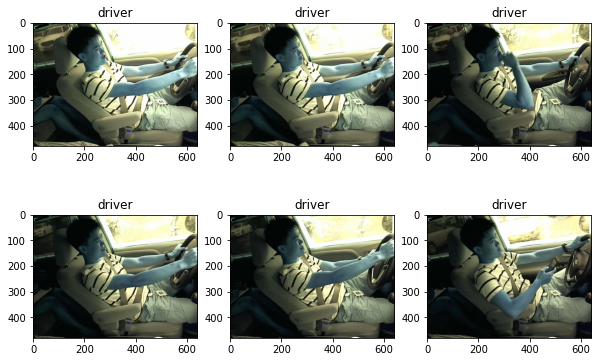

In [ ]:
import cv2

driver_images= []
driver_images.append(cv2.imread(train_dir + '/' + train_df['img'][0]))
driver_images.append(cv2.imread(train_dir + '/' + train_df['img'][1]))
driver_images.append(cv2.imread(train_dir + '/' + train_df['img'][20]))

driver_images.append(cv2.imread(train_dir + '/' + train_df['img'][50]))
driver_images.append(cv2.imread(train_dir + '/' + train_df['img'][51]))
driver_images.append(cv2.imread(train_dir + '/' + train_df['img'][100]))

labels = ['driver', 'driver', 'driver', 'driver', 'driver', 'driver']

import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])
for x in range(0, 6):
  plt.subplot(3, 3, x+1)
  plt.imshow(driver_images[x])
  plt.title(labels[x])
  x += 1

plt.show()

In [ ]:
from keras import applications
from efficientnet.keras import EfficientNetB0
from keras import callbacks
from keras.models import Sequential

In [ ]:
train_df['classname'] = train_df['classname'].astype('str')

# **Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.10,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='img',
    y_col='classname',
    target_size=(224,224),
    subset='training',
    batch_size=1024,
    shuffle=True,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='img',
    y_col='classname',
    target_size=(224,224),
    subset='validation',
    batch_size=256,
    shuffle=True,
    class_mode='categorical'
)

Found 20182 validated image filenames belonging to 10 classes.
Found 2242 validated image filenames belonging to 10 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

Found 79726 images belonging to 9 classes.


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
NUM_CLASSES=10

In [ ]:
import tensorflow as tf

model = build_model(num_classes=NUM_CLASSES)

epochs = 25 
hist = model.fit_generator(train_generator, epochs=epochs, validation_data=val_generator, verbose=2)
plot_hist(hist)

16809984/16804768 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
20/20 - 366s - loss: 2.0599 - accuracy: 0.3571 - val_loss: 2.2750 - val_accuracy: 0.1329
Epoch 2/25
20/20 - 326s - loss: 1.4997 - accuracy: 0.5033 - val_loss: 2.0761 - val_accuracy: 0.1829
Epoch 3/25
20/20 - 323s - loss: 1.3958 - accuracy: 0.5303 - val_loss: 2.1061 - val_accuracy: 0.1401
Epoch 4/25
20/20 - 323s - loss: 1.3420 - accuracy: 0.5486 - val_loss: 2.0848 - val_accuracy: 0.1905
Epoch 5/25
20/20 - 321s - loss: 1.3458 - accuracy: 0.5491 - val_loss: 2.1868 - val_accuracy: 0.1311
Epoch 6/25
20/20 - 321s - loss: 1.3430 - accuracy: 0.5494 - val_loss: 2.0519 - val_accuracy: 0.2248
Epoch 7/25
20/20 - 320s - loss: 1.3334 - accuracy: 0.5523 - val_loss: 2.0298 - val_accuracy: 0.2261
Epoch 8/25
20/20 - 319s - loss: 1.3248 - accuracy: 0.5569 - val_loss: 2.1075 - val_accuracy: 0.1985
Epoch 9/25
20/20 - 320s - loss: 1.3107 - accuracy: 0.5583 - val_loss: 2.0938 - val_accuracy: 0.2038
Epoch 10/25
20/20 - 319s - loss: 1.3098 - accuracy: 0.5573 - val_loss: 2.0365 - val_accuracy: 0.2034

NameError: ignored

In [ ]:
from keras.layers import Dense
from keras.optimizers import Adam

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False,
    pooling='max'
)

efficient_net.trainable = False

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               14520     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1210      
Total params: 4,219,021
Trainable params: 169,450
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = 7
)

#**Model with SGD optimizer, learning_rate=0.01 and dropout of 0.5**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.10,
    rotation_range=40,
    samplewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='img',
    y_col='classname',
    target_size=(32,32),
    #color_mode='grayscale',
    subset='training',
    batch_size=1024,
    shuffle=True,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='img',
    y_col='classname',
    target_size=(32,32),
    #color_mode='grayscale',
    subset='validation',
    batch_size=256,
    shuffle=True,
    class_mode='categorical'
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 20182 validated image filenames belonging to 10 classes.
Found 2242 validated image filenames belonging to 10 classes.


In [ ]:
from keras.optimizers import SGD
from keras.layers import Dropout

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(units = 10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Functional) (None, 1536)              10783528  
_________________________________________________________________
dense_6 (Dense)              (None, 120)               184440    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               14520     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1210      
Total params: 10,983,698
Trainable params: 10,896,402
Non-trainable params: 87,296
_____________________________________

In [ ]:
model.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs = 25,
    validation_data = val_generator,
    validation_steps = 7
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
20/20 [==============================] - 534s 26s/step - loss: 2.8227 - accuracy: 0.1041 - val_loss: 2.3092 - val_accuracy: 0.0742
Epoch 2/25
20/20 [==============================] - 519s 26s/step - loss: 2.8384 - accuracy: 0.0974 - val_loss: 2.3056 - val_accuracy: 0.1099
Epoch 3/25
20/20 [==============================] - 518s 26s/step - loss: 2.8418 - accuracy: 0.0994 - val_loss: 2.3107 - val_accuracy: 0.1099
Epoch 4/25
20/20 [==============================] - 517s 26s/step - loss: 2.8200 - accuracy: 0.1013 - val_loss: 2.3198 - val_accuracy: 0.1155
Epoch 5/25
20/20 [==============================] - 516s 26s/step - loss: 2.8318 - accuracy: 0.1010 - val_loss: 2.3158 - val_accuracy: 0.1217
Epoch 6/25
20/20 [==============================] - 517s 26s/step - loss: 2.8327 - accuracy: 0.0976 - val_loss: 2.3059 - val_accuracy: 0.1239
Epoch 7/25
20/20 [==============================] - 518s 26s/step - loss: 2.8296 - accuracy: 0.1008 - val_loss: 2.3325 - val_accuracy: 0.1032
Epoch 

KeyboardInterrupt: ignored